In [2]:
 # Run the code cell.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
!pip install shap
import shap
warnings.filterwarnings('ignore')

# Loading the dataset.
csv_file = 'https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/whitehat-ds-datasets/air-quality/AirQualityUCI.csv'
df = pd.read_csv(csv_file, sep=';')

# Dropping the 'Unnamed: 15' & 'Unnamed: 16' columns.
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16'], axis=1) 

# Dropping the null values.
df = df.dropna()

# Creating a Pandas series containing 'datetime' objects.
dt_series = pd.Series(data = [item.split("/")[2] + "-" + item.split("/")[1] + "-" + item.split("/")[0] for item in df['Date']], index=df.index) + ' ' + pd.Series(data=[str(item).replace(".", ":") for item in df['Time']], index=df.index)
dt_series = pd.to_datetime(dt_series)

# Remove the Date & Time columns from the DataFrame and insert the 'dt_series' in it.
df = df.drop(columns=['Date', 'Time'], axis=1)
df.insert(loc=0, column='DateTime', value=dt_series)

# Get the Pandas series containing the year values as integers.
year_series = dt_series.dt.year

# Get the Pandas series containing the month values as integers.
month_series = dt_series.dt.month

# Get the Pandas series containing the day values as integers.
day_series = dt_series.dt.day

# Get the Pandas series containing the days of a week, i.e., Monday, Tuesday, Wednesday etc.
day_name_series = dt_series.dt.day_name()

# Add the 'Year', 'Month', 'Day' and 'Day Name' columns to the DataFrame.
df['Year'] = year_series
df['Month'] = month_series
df['Day'] = day_series
df['Day Name'] = day_name_series

# Sort the DataFrame by the 'DateTime' values in the ascending order. Also, display the first 10 rows of the DataFrame.
df = df.sort_values(by='DateTime')

# Create a function to replace the commas with periods in a Pandas series.
def comma_to_period(series):
    new_series = pd.Series(data=[float(str(item).replace(',', '.')) for item in series], index=df.index)
    return new_series

# Apply the 'comma_to_period()' function on the ''CO(GT)', 'C6H6(GT)', 'T', 'RH' and 'AH' columns.
cols_to_correct = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH'] # Create a list of column names.
for col in cols_to_correct: # Iterate through each column
    df[col] = comma_to_period(df[col]) # Replace the original column with the new series.

# Remove all the columns from the 'df' DataFrame containing more than 10% garbage value.
df = df.drop(columns=['NMHC(GT)', 'CO(GT)', 'NOx(GT)', 'NO2(GT)'], axis=1)

# Create a new DataFrame containing records for the years 2004 and 2005.
aq_2004_df = df[df['Year'] == 2004]
aq_2005_df = df[df['Year'] == 2005]

# Replace the -200 value with the median values for each column having indices between 1 and -4 (excluding -4) for the 2004 year DataFrame.
for col in aq_2004_df.columns[1:-4]:
  median = aq_2004_df.loc[aq_2004_df[col] != -200, col].median()
  aq_2004_df[col] = aq_2004_df[col].replace(to_replace=-200, value=median)

# Repeat the same exercise for the 2005 year DataFrame.
for col in aq_2005_df.columns[1:-4]:
  median = aq_2005_df.loc[aq_2005_df[col] != -200, col].median()
  aq_2005_df[col] = aq_2005_df[col].replace(to_replace=-200, value=median)

# Group the DataFrames about the 'Month' column.
group_2004_month = aq_2004_df.groupby(by='Month')
group_2005_month = aq_2005_df.groupby(by='Month')

# Concatenate the two DataFrames for 2004 and 2005 to obtain one DataFrame.
df = pd.concat([aq_2004_df, aq_2005_df])

# Information of the DataFrame.
df.info()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DateTime       9357 non-null   datetime64[ns]
 1   PT08.S1(CO)    9357 non-null   float64       
 2   C6H6(GT)       9357 non-null   float64       
 3   PT08.S2(NMHC)  9357 non-null   float64       
 4   PT08.S3(NOx)   9357 non-null   float64       
 5   PT08.S4(NO2)   9357 non-null   float64       
 6   PT08.S5(O3)    9357 non-null   float64       
 7   T              9357 non-null   float64       
 8   RH             9357 non-null   float64       
 9   AH             9357 non-null   float64       
 10  Year           9357 non-null   int64         
 11  Month          9357 non-null   int64         
 12  Day            9357 non-null   int64         
 13  Day Name       9357 non-

In [3]:
dt_series.head()

0   2004-03-10 18:00:00
1   2004-03-10 19:00:00
2   2004-03-10 20:00:00
3   2004-03-10 21:00:00
4   2004-03-10 22:00:00
dtype: datetime64[ns]

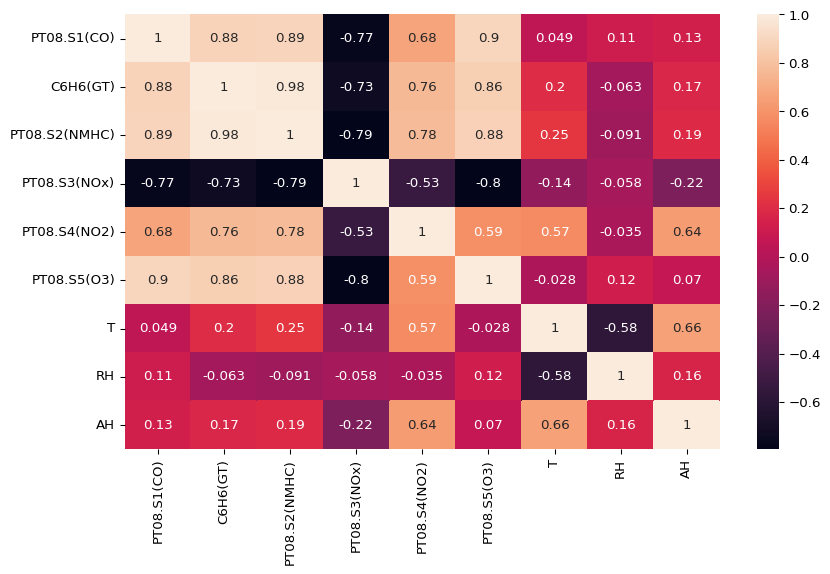

In [4]:
# Heatmap to pinpoint the columns in the 'df' DataFrame exhibiting high correlation.
corr_df = df.iloc[:, 1:-4].corr()
plt.figure(figsize = (10, 6), dpi = 96)
sns.heatmap(data = corr_df, annot = True) # 'annot=True' fills the R values in the heatmap cells.
plt.show()

In [5]:
# Splitting the DataFrame into the train and test sets.
from sklearn.model_selection import train_test_split

X = df['T'] # Pandas DataFrame containing only feature variables
y = df['RH'] # Pandas Series containing the target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.40, random_state = 42) # Test set will have 33% of the values.

In [6]:
# Print the dimensions of the feature and target variable arrays/series.
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5614,)
(5614,)
(3743,)
(3743,)


In [7]:
# Create two-dimensional NumPy arrays from one-dimensional Pandas series for the feature and target variables.
type(X_train.values)
X_train_reshaped= X_train.values.reshape(-1,1)
y_train_reshaped= y_train.values.reshape(-1,1)
X_test_reshaped= X_test.values.reshape(-1,1)
y_test_reshaped= y_test.values.reshape(-1,1)
print(X_train_reshaped.shape)
print(y_train_reshaped.shape)
print(X_test_reshaped.shape)
print(y_test_reshaped.shape)

(5614, 1)
(5614, 1)
(3743, 1)
(3743, 1)


In [8]:
# Deploy linear regression model using the 'sklearn.linear_model' module.
from sklearn.linear_model import LinearRegression
# 2. Create an object of the 'LinearRegression' class.
lin_reg= LinearRegression()
# 3. Call the 'fit()' function
lin_reg.fit(X_train_reshaped,y_train_reshaped)
# 4. Print the slope and intercept values.
slope= float(lin_reg.coef_)
intercept= lin_reg.intercept_
print(slope)
print(intercept)


-1.1023206307694593
[69.58675499]


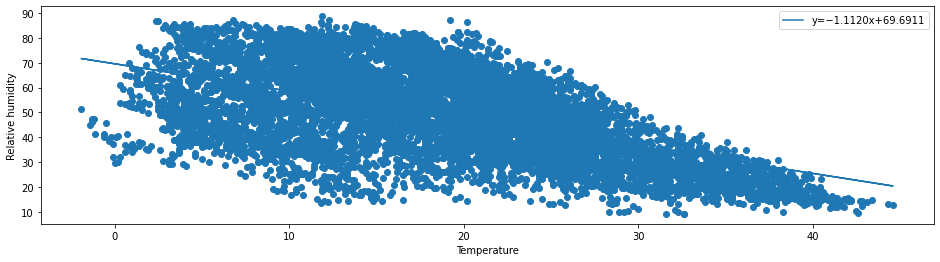

In [9]:
 # Plot the regression line in the scatter plot between relative humidity and temperature values.
plt.figure(figsize=(16,4))
plt.scatter(df['T'],df['RH'])
plt.plot(df['T'], slope*df['T']+intercept,label= 'y=−1.1120x+69.6911')
plt.xlabel('Temperature')
plt.ylabel('Relative humidity')
plt.legend()
plt.show()

In [10]:
# Evaluate the linear regression model using the 'r2_score', 'mean_squared_error' & 'mean_absolute_error' functions of the 'sklearn' module.
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

y_train_pred = lin_reg.predict(X_train_reshaped)
y_test_pred = lin_reg.predict(X_test_reshaped)

print(f"Train Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_train_reshaped, y_train_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_train_reshaped, y_train_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train_reshaped, y_train_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train_reshaped, y_train_pred):.3f}")
      
print(f"\n\nTest Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_test_reshaped, y_test_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_test_reshaped, y_test_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test_reshaped, y_test_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_reshaped, y_test_pred):.3f}")

Train Set
--------------------------------------------------
R-squared: 0.321
Mean Squared Error: 194.969
Root Mean Squared Error: 13.963
Mean Absolute Error: 11.287


Test Set
--------------------------------------------------
R-squared: 0.347
Mean Squared Error: 189.056
Root Mean Squared Error: 13.750
Mean Absolute Error: 11.195


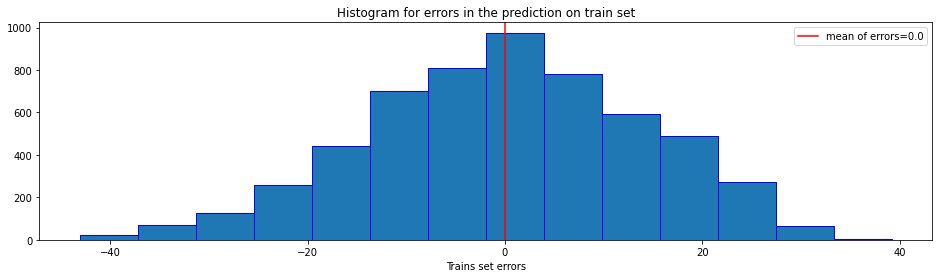

In [11]:
# Create a histogram for the errors obtained in the predicted values for the train set.
errors_train= y_train_reshaped-y_train_pred
plt.figure(figsize=(16,4))
plt.hist(errors_train,bins='sturges',edgecolor='blue')
plt.title('Histogram for errors in the prediction on train set')
plt.axvline(x=errors_train.mean(),label= f'mean of errors={round(errors_train.mean(),3)}',color='red')
plt.xlabel('Trains set errors')
plt.legend()
plt.show()

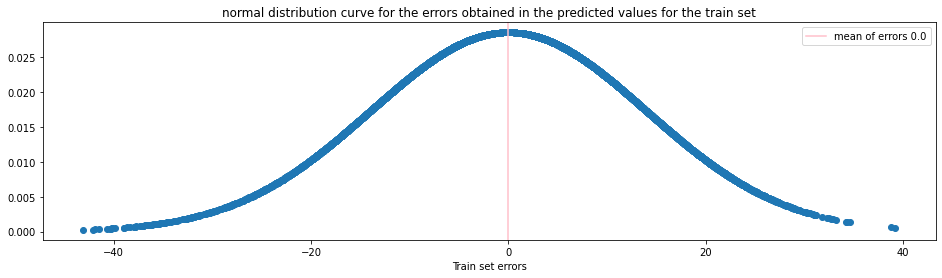

In [12]:
# Apply the 'norm.pdf()' function to get the probabilities and then create a normal distribution curve again for the train set errors.
from scipy.stats import norm
plt.figure(figsize=(16,4))
plt.scatter(errors_train,norm.pdf(errors_train,errors_train.mean(),errors_train.std()))
plt.title('normal distribution curve for the errors obtained in the predicted values for the train set')
plt.axvline(x=errors_train.mean(), label=f'mean of errors {round(errors_train.mean(),3)}',color='pink')
plt.xlabel('Train set errors')
plt.legend()
plt.show()

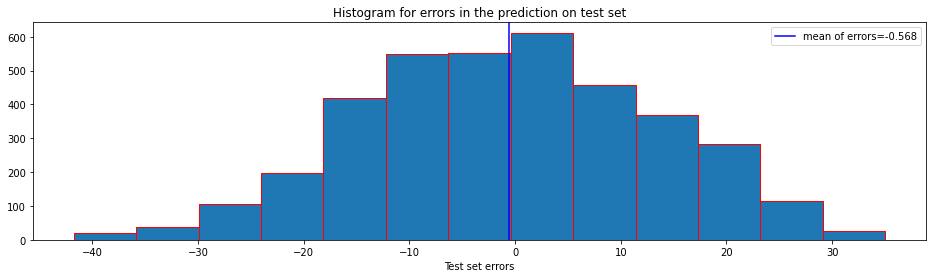

In [13]:
# Create a histogram for the errors obtained in the predicted values for the test set.
errors_test= y_test_reshaped-y_test_pred
plt.figure(figsize=(16,4))
plt.hist(errors_test, bins='sturges',edgecolor='red')
plt.title('Histogram for errors in the prediction on test set')
plt.xlabel('Test set errors')
plt.axvline(x=errors_test.mean(), label=f'mean of errors={round(errors_test.mean(),3)}',color= 'blue')
plt.legend()
plt.show()

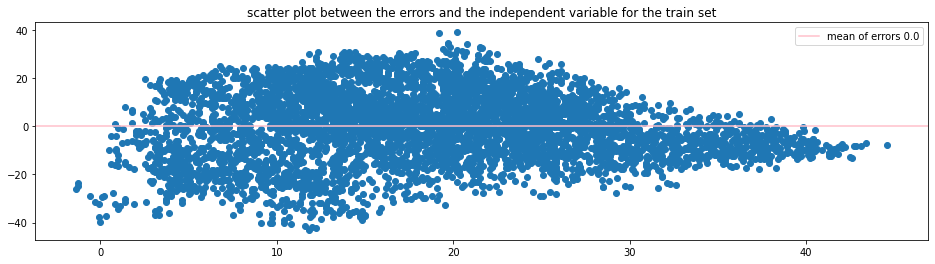

In [14]:
# Create a scatter plot between the errors and the independent variable for the train set
plt.figure(figsize=(16,4))
plt.scatter(X_train,errors_train)
plt.title('scatter plot between the errors and the independent variable for the train set')
plt.axhline(y=errors_train.mean(), label=f'mean of errors {round(errors_train.mean(),3)}',color='pink')
plt.legend()
plt.show()

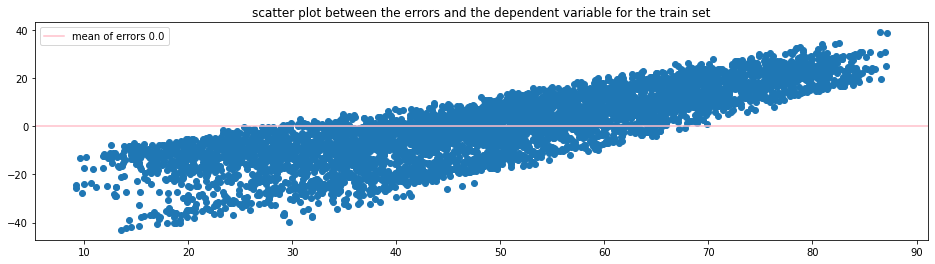

In [15]:
# Create a scatter plot between the errors and the dependent variable for the train set.
plt.figure(figsize=(16,4))
plt.scatter(y_train,errors_train)
plt.title('scatter plot between the errors and the dependent variable for the train set')
plt.axhline(y=errors_train.mean(), label=f'mean of errors {round(errors_train.mean(),3)}',color='pink')
plt.legend()
plt.show()

In [16]:
# Create a list of feature variables.
features= list(df.columns.values[1:-1])
features.remove('RH')
features

['PT08.S1(CO)',
 'C6H6(GT)',
 'PT08.S2(NMHC)',
 'PT08.S3(NOx)',
 'PT08.S4(NO2)',
 'PT08.S5(O3)',
 'T',
 'AH',
 'Year',
 'Month',
 'Day']

In [17]:
# Build a linear regression model using the sklearn module by including all the features listed above.
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
X= df[features]
y=df['RH']
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.33,random_state=42)
y_train_reshaped= y_train.values.reshape(-1,1)
y_test_reshaped= y_test.values.reshape(-1,1)
# Build linear regression model using the 'sklearn.linear_model' module.
sklearn_lin_reg= LinearRegression()
sklearn_lin_reg.fit(X_train,y_train_reshaped)

# Print the value of the intercept i.e. beta-sub-0.
print('Constant= ',sklearn_lin_reg.intercept_)
# Print the names of the features along with the values of their corresponding coefficients.
for i in list(zip(X.columns.values,sklearn_lin_reg.coef_[0])):
  print(i[0],i[1])

Constant=  [-15028.45182325]
PT08.S1(CO) 0.014832794792690625
C6H6(GT) -0.9034641560183382
PT08.S2(NMHC) -0.005880959405385411
PT08.S3(NOx) 0.0015032548783276978
PT08.S4(NO2) 0.026496502045666503
PT08.S5(O3) -0.001065741763271788
T -2.354919067592639
AH 29.551742104329783
Year 7.505153097892558
Month 1.1678609682998067
Day 0.03523212478929974


In [18]:
# Evaluate the linear regression model using the 'r2_score', 'mean_squared_error' & 'mean_absolute_error' functions of the 'sklearn' module.
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

y_train_pred = sklearn_lin_reg.predict(X_train)
y_test_pred = sklearn_lin_reg.predict(X_test)

print(f"Train Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_train_reshaped, y_train_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_train_reshaped, y_train_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train_reshaped, y_train_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train_reshaped, y_train_pred):.3f}")
      
print(f"\n\nTest Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_test_reshaped, y_test_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_test_reshaped, y_test_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test_reshaped, y_test_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_reshaped, y_test_pred):.3f}")

Train Set
--------------------------------------------------
R-squared: 0.879
Mean Squared Error: 35.116
Root Mean Squared Error: 5.926
Mean Absolute Error: 4.572


Test Set
--------------------------------------------------
R-squared: 0.879
Mean Squared Error: 34.702
Root Mean Squared Error: 5.891
Mean Absolute Error: 4.564


In [19]:
# Create data frames for the features and target again and also split them into the train and test sets.
X= df[features]
y=df['RH']
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.33,random_state=42)

In [20]:
# S2.2: Build a linear regression model using the 'statsmodels.api' module.
import statsmodels.api as sm

# Add a constant to get an intercept
X_train_sm= sm.add_constant(X_train)

# Fit the regression line using 'OLS'
sm_lin_reg= sm.OLS(y_train,X_train_sm).fit()

# Print the parameters, i.e. the intercept and the slope of the regression line fitted
sm_lin_reg.params

const           -15028.451823
PT08.S1(CO)          0.014833
C6H6(GT)            -0.903464
PT08.S2(NMHC)       -0.005881
PT08.S3(NOx)         0.001503
PT08.S4(NO2)         0.026497
PT08.S5(O3)         -0.001066
T                   -2.354919
AH                  29.551742
Year                 7.505153
Month                1.167861
Day                  0.035232
dtype: float64

In [21]:
# Subtract the constant and the coefficient values obtained through 'sklearn' from the ones obtained through 'statsmodels.api'.
print(sm_lin_reg.params.values[0]-sklearn_lin_reg.intercept_)
a= sm_lin_reg.params.values[0]-sklearn_lin_reg.intercept_[0]
print(round(a))
print(sm_lin_reg.params.values[1:]-sklearn_lin_reg.coef_)

[3.65649612e-07]
0
[[ 5.27512062e-14  9.94226923e-12 -1.16444181e-13 -1.02911820e-13
  -3.15528853e-13 -5.48693035e-15 -3.01980663e-14  8.73505712e-11
  -1.82259541e-10 -1.58075775e-11 -8.20031543e-13]]


In [22]:
# Build a linear regression model using the 'statsmodels.api' module.
import statsmodels.api as sm

# Create data frames for the features and target again and also split them into the train and test sets.
X = df[features]
y = df['RH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42) # Test set will have 33% of the values.

# Add a constant to get an intercept
X_train_sm = sm.add_constant(X_train)

# Fit the regression line using 'OLS'
lr = sm.OLS(y_train, X_train_sm).fit()

# Print the parameters, i.e. the intercept and the slope of the regression line fitted
lr.params

const           -15028.451823
PT08.S1(CO)          0.014833
C6H6(GT)            -0.903464
PT08.S2(NMHC)       -0.005881
PT08.S3(NOx)         0.001503
PT08.S4(NO2)         0.026497
PT08.S5(O3)         -0.001066
T                   -2.354919
AH                  29.551742
Year                 7.505153
Month                1.167861
Day                  0.035232
dtype: float64

In [23]:
# Performing a summary operation lists out all the different parameters of the regression line fitted
print(sm_lin_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                     RH   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     4115.
Date:                Wed, 25 May 2022   Prob (F-statistic):               0.00
Time:                        15:26:57   Log-Likelihood:                -20050.
No. Observations:                6269   AIC:                         4.012e+04
Df Residuals:                    6257   BIC:                         4.020e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.503e+04   1240.167    -12.118

In [24]:
# Add a new column to the 'X_train' DataFrame such that each item of the column is 1.
X_train.insert(loc=0,column='Ones',value=1)
X_train.head()

,Ones,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,AH,Year,Month,Day
2653,1,1384.0,23.5,1391.0,552.0,2316.0,1548.0,24.7,1.5201,2004,6,29
5471,1,1277.0,11.8,1043.0,614.0,1631.0,1155.0,25.0,1.5630,2004,10,24
5681,1,1570.0,32.9,1617.0,426.0,2170.0,1944.0,22.1,1.4851,2004,11,2
1541,1,1300.0,17.4,1221.0,648.0,1946.0,1401.0,17.5,1.1175,2004,5,13
5651,1,1212.0,15.0,1149.0,562.0,1710.0,1599.0,18.4,1.6370,2004,11,1


In [25]:
# Estimate the values of betas using matrix operations only.
# Get the Z matrix.
Z= np.matmul(np.matrix(X_train.T),np.matrix(X_train))
# Calculate the inverse of Z matrix. 
Z_inv= np.linalg.inv(Z)
# Calculate the U matrix.
U= np.matmul(np.matrix(X_train.T),np.matrix(y_train).reshape(-1,1))
# Calculate the values of betas.
B_train= np.matmul(Z_inv,U)
B_train

matrix([[-1.50284520e+04],
        [ 1.48327948e-02],
        [-9.03464162e-01],
        [-5.88095929e-03],
        [ 1.50325494e-03],
        [ 2.64965022e-02],
        [-1.06574176e-03],
        [-2.35491907e+00],
        [ 2.95517421e+01],
        [ 7.50515318e+00],
        [ 1.16786098e+00],
        [ 3.52321250e-02]])

In [26]:
# Print the values of betas obtained using the 'statsmodels.api' module.
lr.params

const           -15028.451823
PT08.S1(CO)          0.014833
C6H6(GT)            -0.903464
PT08.S2(NMHC)       -0.005881
PT08.S3(NOx)         0.001503
PT08.S4(NO2)         0.026497
PT08.S5(O3)         -0.001066
T                   -2.354919
AH                  29.551742
Year                 7.505153
Month                1.167861
Day                  0.035232
dtype: float64

In [27]:
# Subtract the corresponding beta values obtained through matrix operations and 'statsmodels.api' module.
B_train_array= np.array(B_train)
for i in range(len(B_train)):
  print(B_train_array[i][0]-lr.params.values[i])
B_train_array

-0.00017678223593975417
-1.1060952501140697e-11
-6.481003400615748e-09
1.1443982827347154e-10
5.900879199334519e-11
1.325552480280212e-10
4.33588928649975e-13
1.5057199931334253e-10
-3.871922515941151e-08
8.611501556288204e-08
7.67068253360037e-09
2.3993517589415703e-10


array([[-1.50284520e+04],
       [ 1.48327948e-02],
       [-9.03464162e-01],
       [-5.88095929e-03],
       [ 1.50325494e-03],
       [ 2.64965022e-02],
       [-1.06574176e-03],
       [-2.35491907e+00],
       [ 2.95517421e+01],
       [ 7.50515318e+00],
       [ 1.16786098e+00],
       [ 3.52321250e-02]])

In [28]:
# Print the summary of the multiple linear regression model built earlier.
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                     RH   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     4115.
Date:                Wed, 25 May 2022   Prob (F-statistic):               0.00
Time:                        15:26:57   Log-Likelihood:                -20050.
No. Observations:                6269   AIC:                         4.012e+04
Df Residuals:                    6257   BIC:                         4.020e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.503e+04   1240.167    -12.118

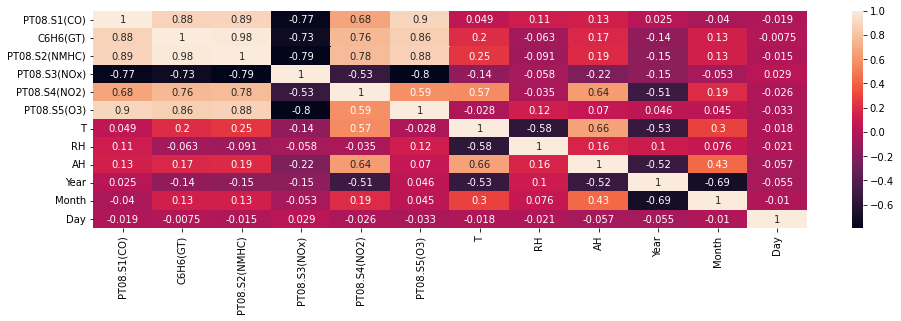

In [29]:
# create a heatmap of a correlation DataFrame of the air quality analysis dataset 
plt.figure(figsize=(16,4))
sns.heatmap(df.corr(), annot=True)
plt.show()

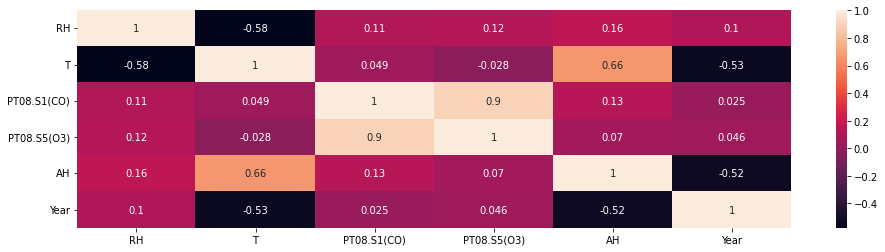

In [30]:
# Create a correlation heatmap between 'RH', 'T', 'PT08.S1(CO)', 'PT08.S5(O3)', 'AH', 'Year' variables.
plt.figure(figsize=(16,4))
sns.heatmap(df[['RH', 'T', 'PT08.S1(CO)', 'PT08.S5(O3)', 'AH', 'Year']].corr(), annot=True)
plt.show()

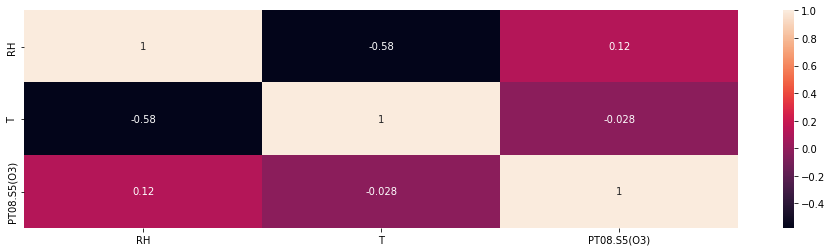

In [31]:
# Create a correlation heatmap between 'RH', 'T', 'PT08.S5(O3)' variables.
plt.figure(figsize=(16,4))
sns.heatmap(df[['RH', 'T','PT08.S5(O3)']].corr(), annot=True)
plt.show()

In [32]:
# Build a linear regression model again with 'T' and 'PT08.S5(O3)' as independent variables to predict 'RH'.
X_train= X_train[['T','PT08.S5(O3)']] 
X_test= X_test[['T','PT08.S5(O3)']] 
# Add a constant to get an intercept
X_train_sm1= sm.add_constant(X_train)
# Fit the regression line using 'OLS'
lr1= sm.OLS(y_train,X_train_sm1).fit()
# Print the parameters, i.e. the intercept and the slope of the regression line fitted
lr1.params

const          64.956429
T              -1.104251
PT08.S5(O3)     0.004509
dtype: float64

In [33]:
# Print the summary table to get all the parameters for the features used to build a linear regression model.
print(lr1.summary())

                            OLS Regression Results                            
Dep. Variable:                     RH   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     1580.
Date:                Wed, 25 May 2022   Prob (F-statistic):               0.00
Time:                        15:26:58   Log-Likelihood:                -25378.
No. Observations:                6269   AIC:                         5.076e+04
Df Residuals:                    6266   BIC:                         5.078e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          64.9564      0.623    104.206      

<Figure size 7200x7200 with 0 Axes>

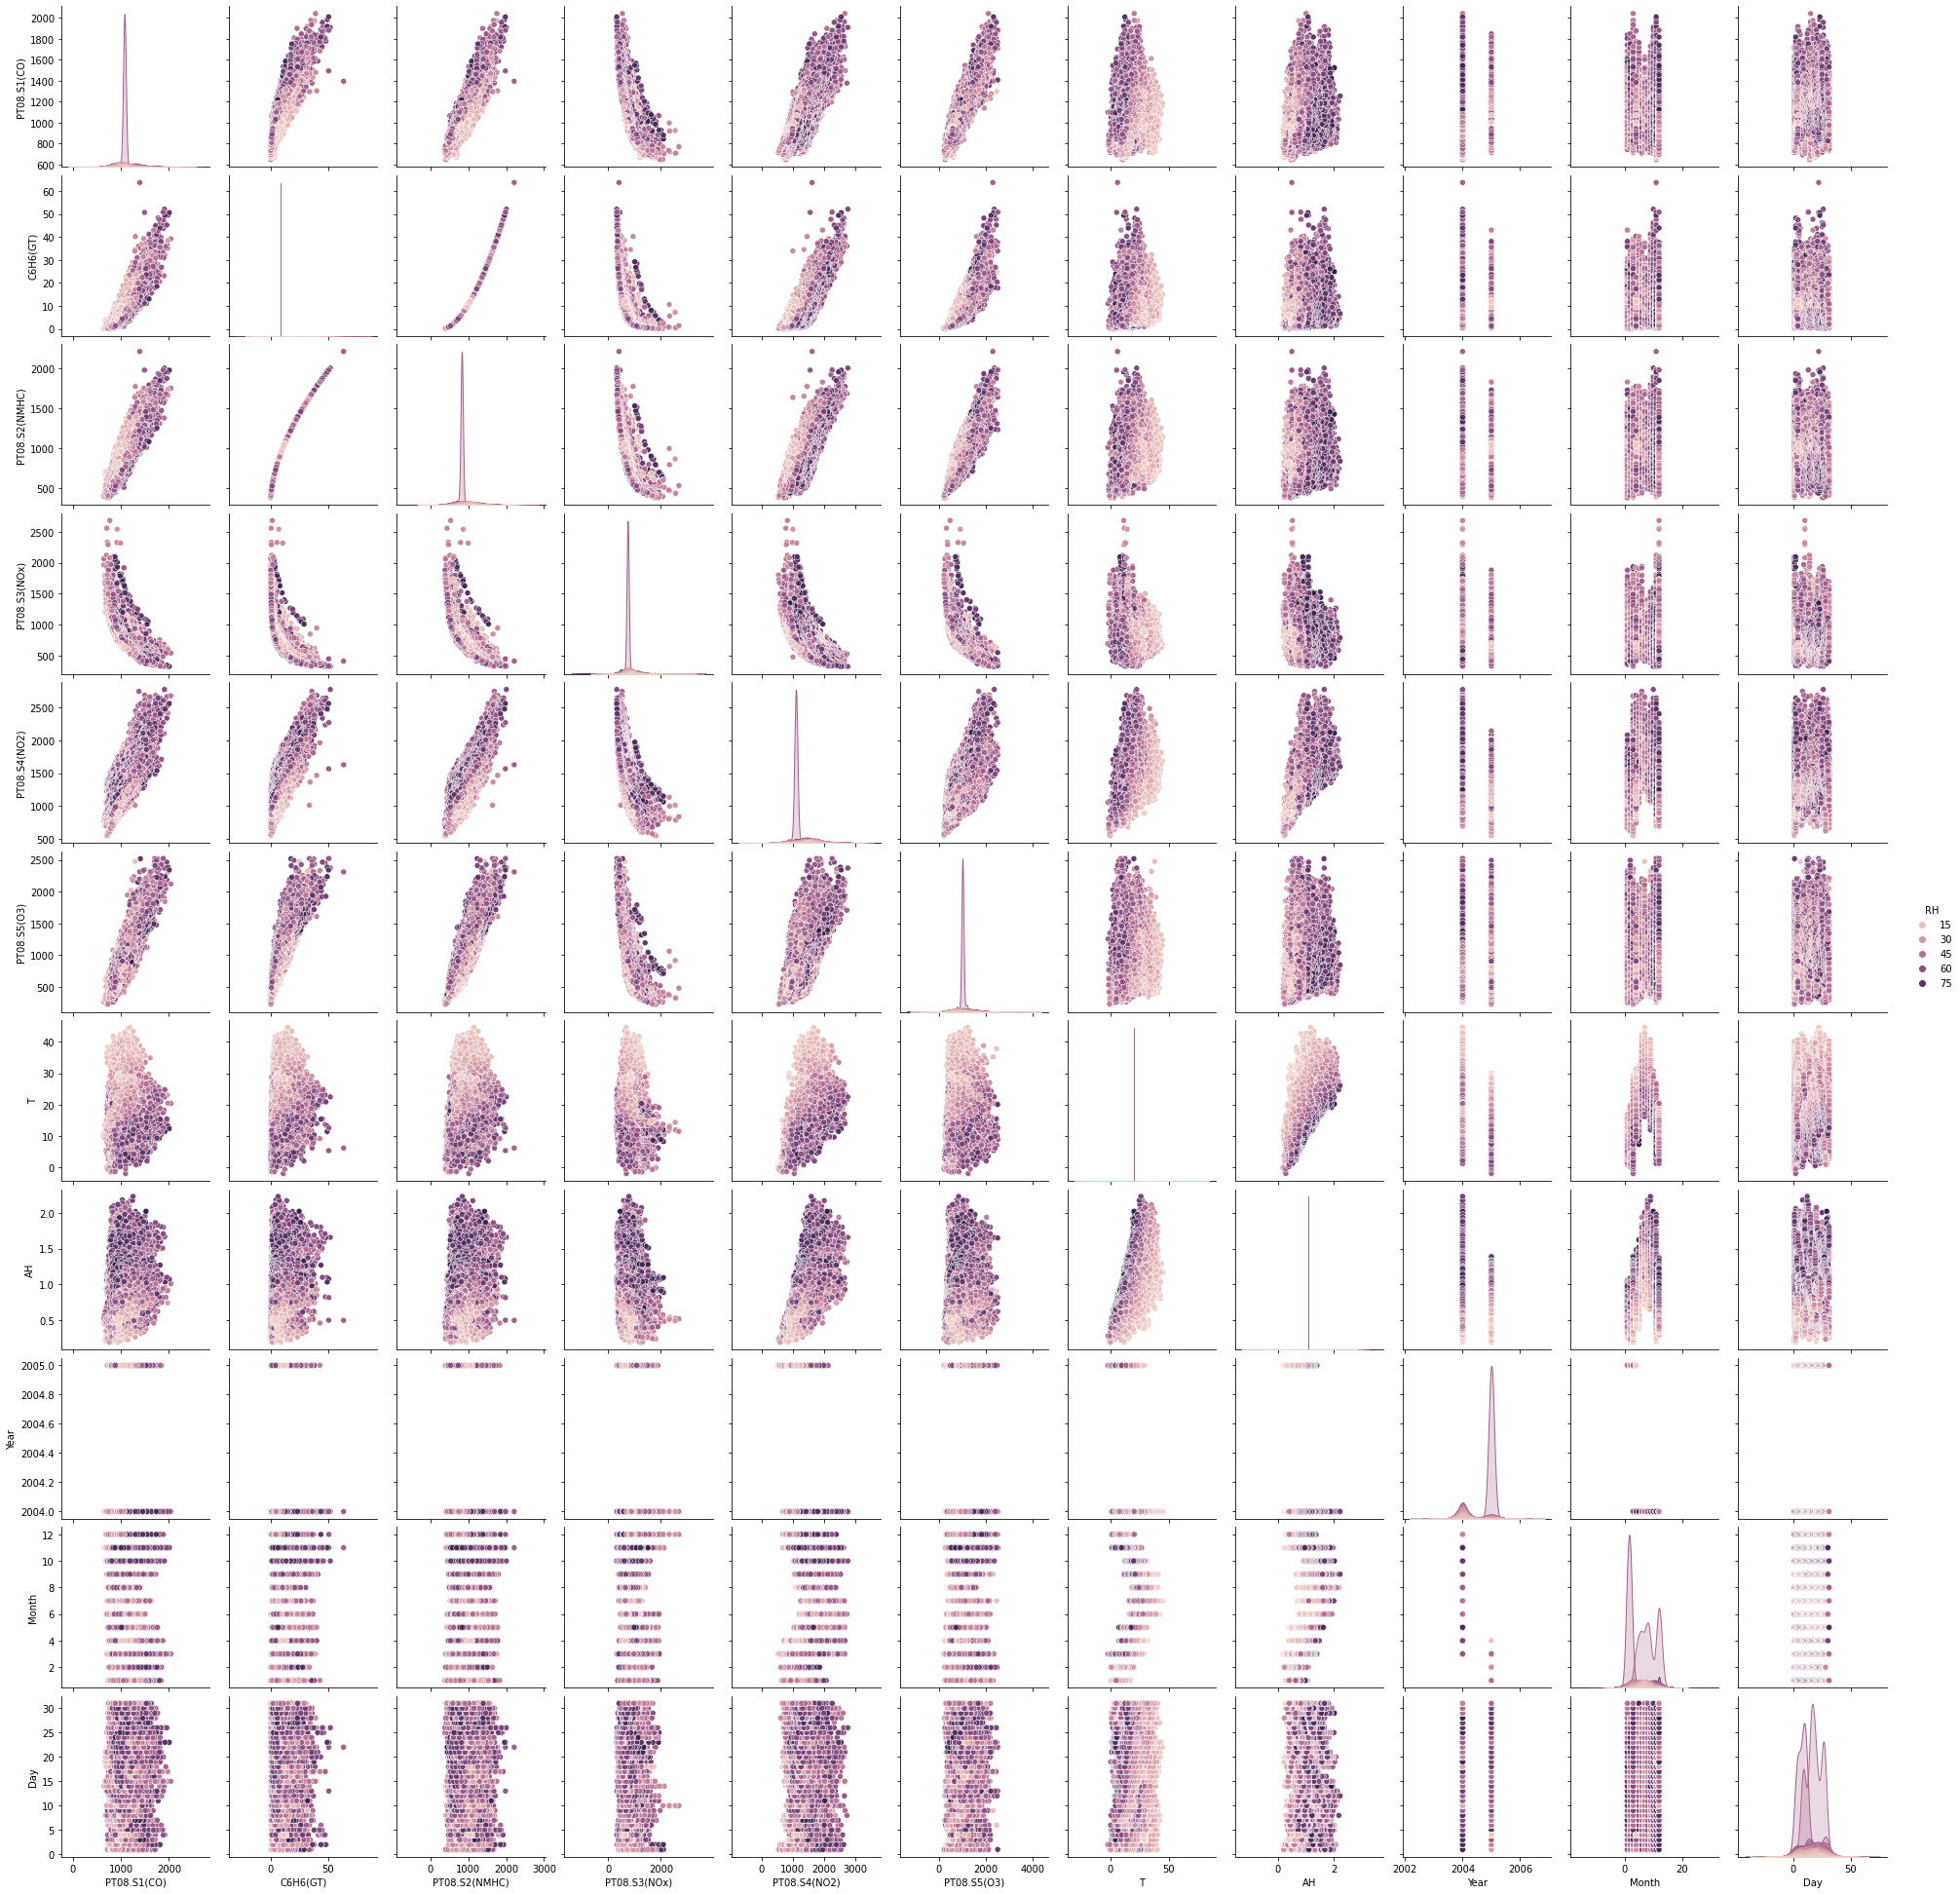

In [34]:
plt.figure(figsize=(100,100))
sns.pairplot(df, hue= 'RH')

In [35]:
from sklearn.ensemble import RandomForestClassifier


In [36]:
#features= df.drop(columns= ['RH','Day Name'])
#features
#features= list(df.columns.values[1:-1])
#features.remove('RH')
#features

In [37]:
X= df[features]
y= df['RH']
y.head()

0    48.9
1    47.7
2    54.0
3    60.0
4    59.6
Name: RH, dtype: float64

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
print(X_train.shape)
y_train.shape

(6269, 11)


(6269,)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DateTime       9357 non-null   datetime64[ns]
 1   PT08.S1(CO)    9357 non-null   float64       
 2   C6H6(GT)       9357 non-null   float64       
 3   PT08.S2(NMHC)  9357 non-null   float64       
 4   PT08.S3(NOx)   9357 non-null   float64       
 5   PT08.S4(NO2)   9357 non-null   float64       
 6   PT08.S5(O3)    9357 non-null   float64       
 7   T              9357 non-null   float64       
 8   RH             9357 non-null   float64       
 9   AH             9357 non-null   float64       
 10  Year           9357 non-null   int64         
 11  Month          9357 non-null   int64         
 12  Day            9357 non-null   int64         
 13  Day Name       9357 non-null   object        
dtypes: datetime64[ns](1), float64(9), int64(3), object(1)
memory usage: 1.3+

In [40]:
model= RandomForestRegressor()
model.fit(X_train,y_train)

RandomForestRegressor()

In [41]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f"Train Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_train, y_train_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_train, y_train_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred):.3f}")
      
print(f"\n\nTest Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_test, y_test_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_test_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred):.3f}")

Train Set
--------------------------------------------------
R-squared: 1.000
Mean Squared Error: 0.059
Root Mean Squared Error: 0.244
Mean Absolute Error: 0.156


Test Set
--------------------------------------------------
R-squared: 0.999
Mean Squared Error: 0.388
Root Mean Squared Error: 0.623
Mean Absolute Error: 0.395


 99%|===================| 3060/3088 [01:07<00:00]       

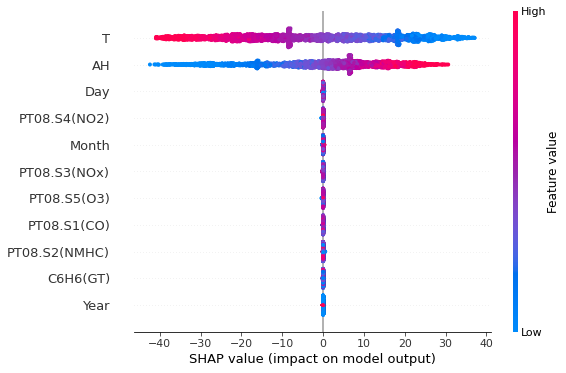

In [42]:
explainer = shap.TreeExplainer(model, X_test)
shap_values= explainer.shap_values(X_test,check_additivity= False)
shap.summary_plot(shap_values,X_test)

In [43]:
model.score(X_test,y_test)

0.9986435763859214

In [44]:
model.predict(X_test)

array([34.935, 50.223, 32.647, ..., 46.868, 78.707, 70.396])

In [45]:
y_train.head()

2653    49.5
5471    50.1
5681    56.6
1541    56.4
5651    78.1
Name: RH, dtype: float64

In [46]:
np.mean(y_train)

49.48180730579037

In [47]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [48]:
model_2= HistGradientBoostingRegressor()
model_2.fit(X_train,y_train)

HistGradientBoostingRegressor()

In [49]:
model_2.score(X_test,y_test)

0.9978419756294824

In [50]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

y_train_pred = model_2.predict(X_train)
y_test_pred = model_2.predict(X_test)

print(f"Train Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_train, y_train_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_train, y_train_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred):.3f}")
      
print(f"\n\nTest Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_test, y_test_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_test_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred):.3f}")

Train Set
--------------------------------------------------
R-squared: 0.999
Mean Squared Error: 0.364
Root Mean Squared Error: 0.604
Mean Absolute Error: 0.453


Test Set
--------------------------------------------------
R-squared: 0.998
Mean Squared Error: 0.617
Root Mean Squared Error: 0.786
Mean Absolute Error: 0.572


In [51]:
model.feature_importances_

array([2.61322837e-04, 1.59535234e-04, 2.32340881e-04, 3.20538740e-04,
       3.41486795e-04, 3.16396851e-04, 5.94312027e-01, 4.03364127e-01,
       3.08893149e-05, 2.45795158e-04, 4.15540109e-04])

Text(0.5, 1.0, 'Random Forest Feature Importance')

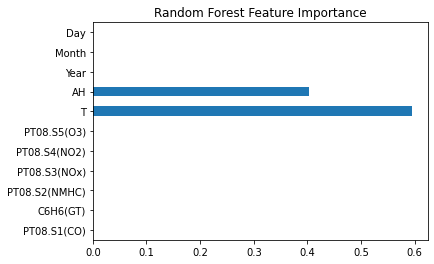

In [52]:
(pd.Series(model.feature_importances_, index=X.columns).plot(kind='barh')) 
plt.title('Random Forest Feature Importance')

 99%|===================| 3062/3088 [00:16<00:00]       

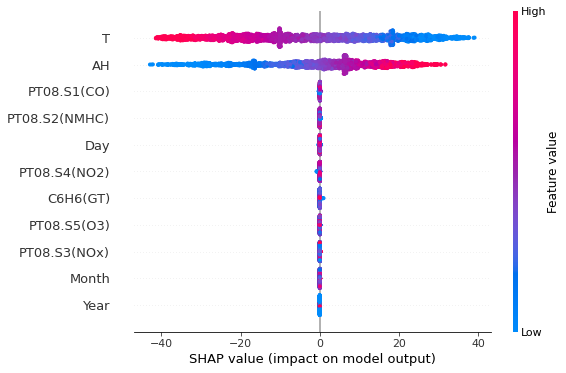

In [62]:
explainer = shap.TreeExplainer(model_2, X_test)
shap_values= explainer.shap_values(X_test,check_additivity= False)
shap.summary_plot(shap_values,X_test)

In [54]:
 from sklearn.ensemble import GradientBoostingRegressor

In [55]:
model_3= GradientBoostingRegressor()
model_3.fit(X_train,y_train)

GradientBoostingRegressor()

In [65]:
y_train_pred = model_3.predict(X_train)
y_test_pred = model_3.predict(X_test)

print(f"Train Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_train, y_train_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_train, y_train_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred):.3f}")
      
print(f"\n\nTest Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_test, y_test_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_test_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred):.3f}")

Train Set
--------------------------------------------------
R-squared: 0.990
Mean Squared Error: 2.766
Root Mean Squared Error: 1.663
Mean Absolute Error: 1.266


Test Set
--------------------------------------------------
R-squared: 0.989
Mean Squared Error: 3.202
Root Mean Squared Error: 1.789
Mean Absolute Error: 1.364


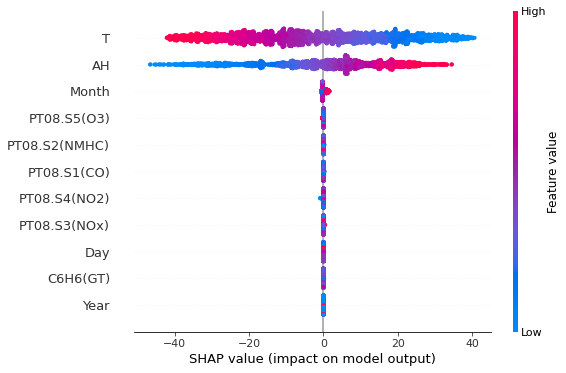

In [82]:
explainer = shap.TreeExplainer(model_3, X_test)
shap_values= explainer.shap_values(X_test,check_additivity= False)
shap.summary_plot(shap_values,X_test)

In [83]:
shap.dependence_plot(shap_values, X_test)

AttributeError: ignored

In [2]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 9.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=b3ac602e6c66e399e2b631b39979afafdcb604df04f90a296e180ebf67c72c81
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [2]:
from lime import lime_tabular
explainer= lime_tabular.LimeTabularExplainer(training_data= np.array(X_train, mode='regression', feature_name= X_train.columns, categorical_features=[0])
exp= explainer.explain_instance(data_row= X_test.iloc[4],
                                predict_fn= model.predict)
exp.show_in_notebook(show_table= True)

SyntaxError: ignored